In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import scipy.optimize as opt



In [2]:
#making a first order CSTR for E. Coli decay

In [3]:
Ea = 84900
R = 8.314
k0 = 2.83e13
def ktemp(T):
    return k0 * np.exp(-Ea / (R * T))

In [16]:
def knatural(T): #this is just natural decay
    k_nat = 0.37 #1/day
    Tref = 293 #K
    thetan = 0.951
    knatT = k_nat * (thetan**(T-Tref))
    return knatT/(24*60)

In [17]:
def ksolar(I, T): #how UV impacts decay
    k_sol = 1.8
    thetas = 1
    Tref = 293
    Icon = I*(86400/1e6)
    ksT = k_sol*(thetas**(T-Tref))
    ksolday = ksT*Icon
    return ksolday/(24*60)

In [18]:
def kpred(D,T): #filter feeders
    kp = 0.020
    thetap = 1
    Tref = 293
    kpT = kp*(thetap**(T-Tref))
    kpday = kpT*D
    return kpday /(24*60)

In [19]:
def cstrall(c, t, Q, V, c0, T, Isol, Ddap):
    knat = knatural(T)
    ksol = ksolar(Isol, T)
    kpr = kpred(Ddap, T)
    
    ktot = knat + ksol + kpr
    
    dcdt = (Q/V)*(c0-c) - ktot*c
    return dcdt

#initial parameters
V = 1000 
Q = 10 
c0 = 1.7e6
T = 298 #initial values from paper Hernandez-Crespo
Isol = 800
Ddap = 10

tau = V/Q
knat = knatural(T)
ksol = ksolar(Isol, T)
kpr = kpred(Ddap, T)
ktot = knat + ksol + kpr

c_ss = c0 / (1 + ktot * tau)

In [20]:
time = np.linspace(0, 300, 100)
cinit = 0
csol = odeint(cstrall, cinit, time, args=(Q,V,c0,T,Isol, Ddap))

Text(0, 0.5, 'concentration')

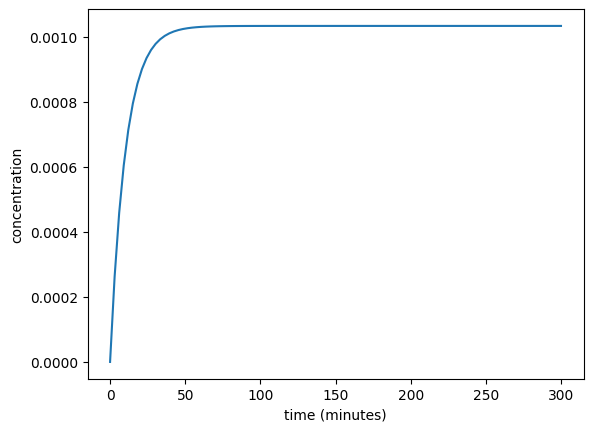

In [21]:
plt.plot(time, csol/(c0*100))
plt.xlabel('time (minutes)')
plt.ylabel('concentration')

In [ ]:
#KMC

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  

%matplotlib inline


In [76]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42) 

# --- 2. DEFINE BASELINE PARAMETERS ---
# We generate these ONCE here. Cells 2, 3, and 4 will use these exact variables.

bacteria0 = 150.0      # Initial count
end_time  = 50.0       # Duration (days)

# Randomly generate the rates for this specific "Pond Scenario"
k_in     = np.random.uniform(20, 50)   # Pollution entering
k_growth = np.random.uniform(0.1, 0.4) # Bacterial growth

# Death rate depends on crowding (just for logic)
if bacteria0 > 100:
    k_death = np.random.uniform(0.5, 0.8)
else:
    k_death = np.random.uniform(0.2, 0.5)

# Washout rate (Flow)
k_wash = np.random.uniform(0.1, 0.3)

# Calculate the Net Decay Rate
# If this is positive, the pond works. If negative, it fails.
k_net = (k_death + k_wash) - k_growth

print("--- BASELINE PARAMETERS (Fixed for Cells 2, 3, & 4) ---")
print(f"Initial Bacteria : {bacteria0}")
print(f"k_in (Inflow)    : {k_in:.3f} bacteria/day")
print(f"k_growth         : {k_growth:.3f} 1/day")
print(f"k_death          : {k_death:.3f} 1/day")
print(f"k_wash           : {k_wash:.3f} 1/day")
print("-" * 30)
print(f"NET DECAY RATE   : {k_net:.3f}")
if k_net > 0:
    print("STATUS           : STABLE (Bacteria will decay)")
else:
    print("STATUS           : UNSTABLE (Bacteria will explode)")

--- BASELINE PARAMETERS (Fixed for Cells 2, 3, & 4) ---
Initial Bacteria : 150.0
k_in (Inflow)    : 31.236 bacteria/day
k_growth         : 0.385 1/day
k_death          : 0.720 1/day
k_wash           : 0.220 1/day
------------------------------
NET DECAY RATE   : 0.554
STATUS           : STABLE (Bacteria will decay)


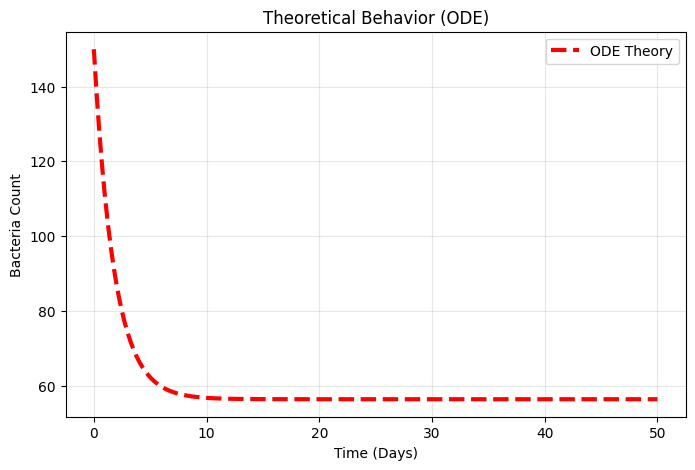

In [77]:
def ode(t, N0, kin, kg, kd, kw):
    k_net_val = (kd + kw) - kg
    
    # Avoid divide by zero if perfectly balanced
    if np.abs(k_net_val) < 1e-9:
        return N0 + kin * t
    
    # Steady State = Input / Net_Decay
    N_ss = kin / k_net_val
    
    # Analytical Solution: N(t) = N_ss + (N0 - N_ss) * exp(-k_net * t)
    return N_ss + (N0 - N_ss) * np.exp(-k_net_val * t)

t_theory = np.linspace(0, end_time, 200)
N_theory = ode(t_theory, bacteria0, k_in, k_growth, k_death, k_wash)

plt.figure(figsize=(8, 5))
plt.plot(t_theory, N_theory, 'r--', linewidth=3, label="ODE Theory")
plt.title(f"Theoretical Behavior (ODE)")
plt.xlabel("Time (Days)")
plt.ylabel("Bacteria Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

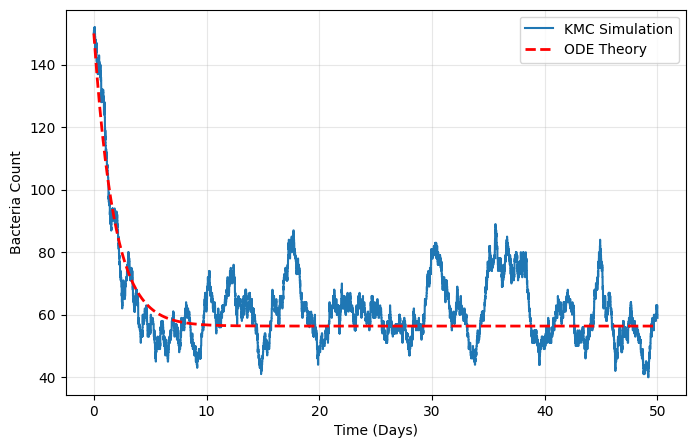

In [78]:
def kmc_simulation(N0, T_end, kin, kg, kd, kw):
    t = 0.0
    N = N0
    times = [t]
    counts = [N]
    
    # Run loop until time is up
    while t < T_end:
        # 1. Calculate Rates for this specific moment
        r_grow = kg * N
        r_in   = kin
        r_die  = kd * N
        r_wash = kw * N
        r_total = r_grow + r_in + r_die + r_wash
        
        if r_total == 0: break
            
        # 2. Time Step (Gillespie)
        dt = -np.log(np.random.rand()) / r_total
        t += dt
        
        # 3. Determine Event
        rand = np.random.rand() * r_total
        
        if rand < r_grow:
            N += 1  # Growth
        elif rand < r_grow + r_in:
            N += 1  # Inflow
        elif rand < r_grow + r_in + r_die:
            N -= 1  # Death
        else:
            N -= 1  # Washout
            
        times.append(t)
        counts.append(N)
        
    return np.array(times), np.array(counts)

t_kmc, n_kmc = kmc_simulation(bacteria0, end_time, k_in, k_growth, k_death, k_wash)

plt.figure(figsize=(8, 5))
plt.step(t_kmc, n_kmc, where='post', color='tab:blue', label="KMC Simulation")
plt.plot(t_theory, N_theory, 'r--', linewidth=2, label="ODE Theory") # Overlay Cell 2 result

plt.xlabel("Time (Days)")
plt.ylabel("Bacteria Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

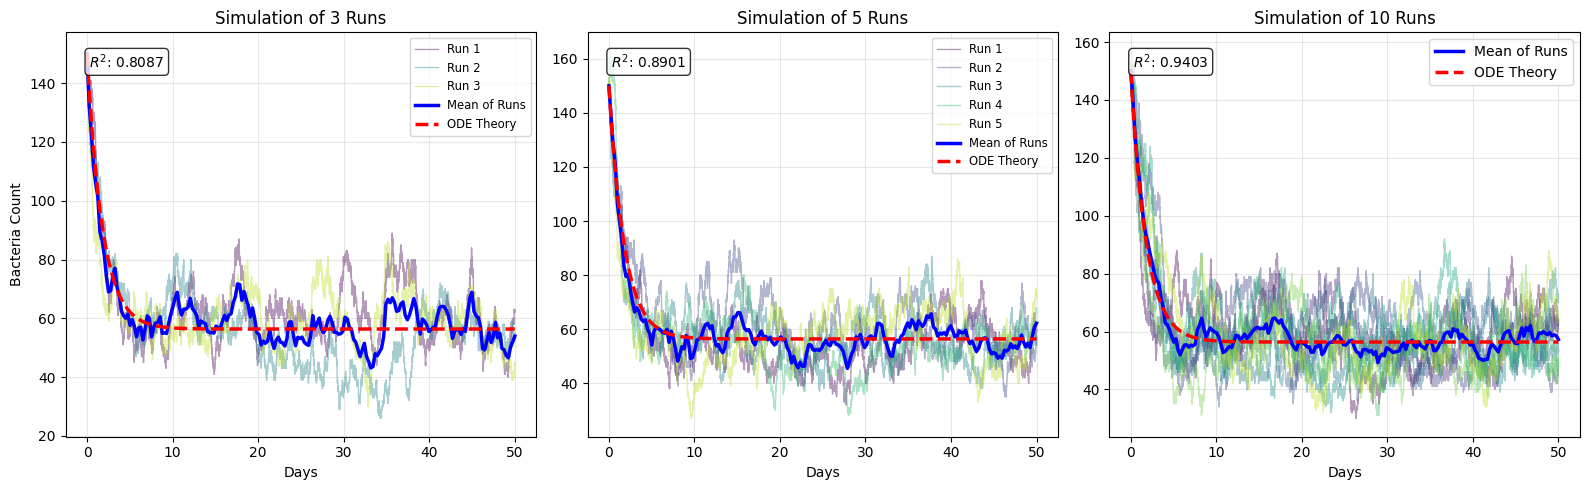

In [71]:
# --- CONVERGENCE CHECK WITH INDIVIDUAL RUNS ---

runs_list = [3, 5, 10]
t_common = np.linspace(0, end_time, 200) # Common time grid for averaging

plt.figure(figsize=(16, 5))

for i, n_runs in enumerate(runs_list):
    # Seed specific to this block to ensure clear graphs
    np.random.seed(42 + i)
    
    all_interp = []
    
    # Set up the subplot
    ax = plt.subplot(1, 3, i+1)
    
    # Generate colors for the individual runs (using a colormap)
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_runs))
    
    # Run loop
    for r in range(n_runs):
        tk, nk = kmc_simulation(bacteria0, end_time, k_in, k_growth, k_death, k_wash)
        
        # PLOT INDIVIDUAL RUN
        # We plot each run with a unique color and low opacity
        ax.step(tk, nk, where='post', color=colors[r], alpha=0.4, linewidth=1, label=f"Run {r+1}")
        
        # Interpolate to common grid so we can average them later
        nk_interp = np.interp(t_common, tk, nk)
        all_interp.append(nk_interp)
    
    # Calculate Mean
    mean_run = np.mean(all_interp, axis=0)
    
    # Calculate R^2 (How well does Mean match Theory?)
    ss_res = np.sum((mean_run - N_theory)**2)
    ss_tot = np.sum((mean_run - np.mean(mean_run))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    # PLOT MEAN AND THEORY ON TOP
    ax.plot(t_common, mean_run, 'b-', linewidth=2.5, label="Mean of Runs")
    ax.plot(t_common, N_theory, 'r--', linewidth=2.5, label="ODE Theory")
    
    # Add text box for R^2
    text_str = f"$R^2$: {r2:.4f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.set_title(f"Simulation of {n_runs} Runs")
    ax.set_xlabel("Days")
    if i == 0: ax.set_ylabel("Bacteria Count")
    ax.grid(True, alpha=0.3)
    
    # Handle Legend: Only show Mean/Theory to keep it clean, 
    # or show everything if n_runs is small
    if n_runs <= 5:
        ax.legend(loc='upper right', fontsize='small')
    else:
        # For 10 runs, just show Mean and Theory in legend to avoid crowding
        handles, labels = ax.get_legend_handles_labels()
        # Filter to keep only Mean and Theory (last 2 items)
        ax.legend(handles[-2:], labels[-2:], loc='upper right')

plt.tight_layout()
plt.show()

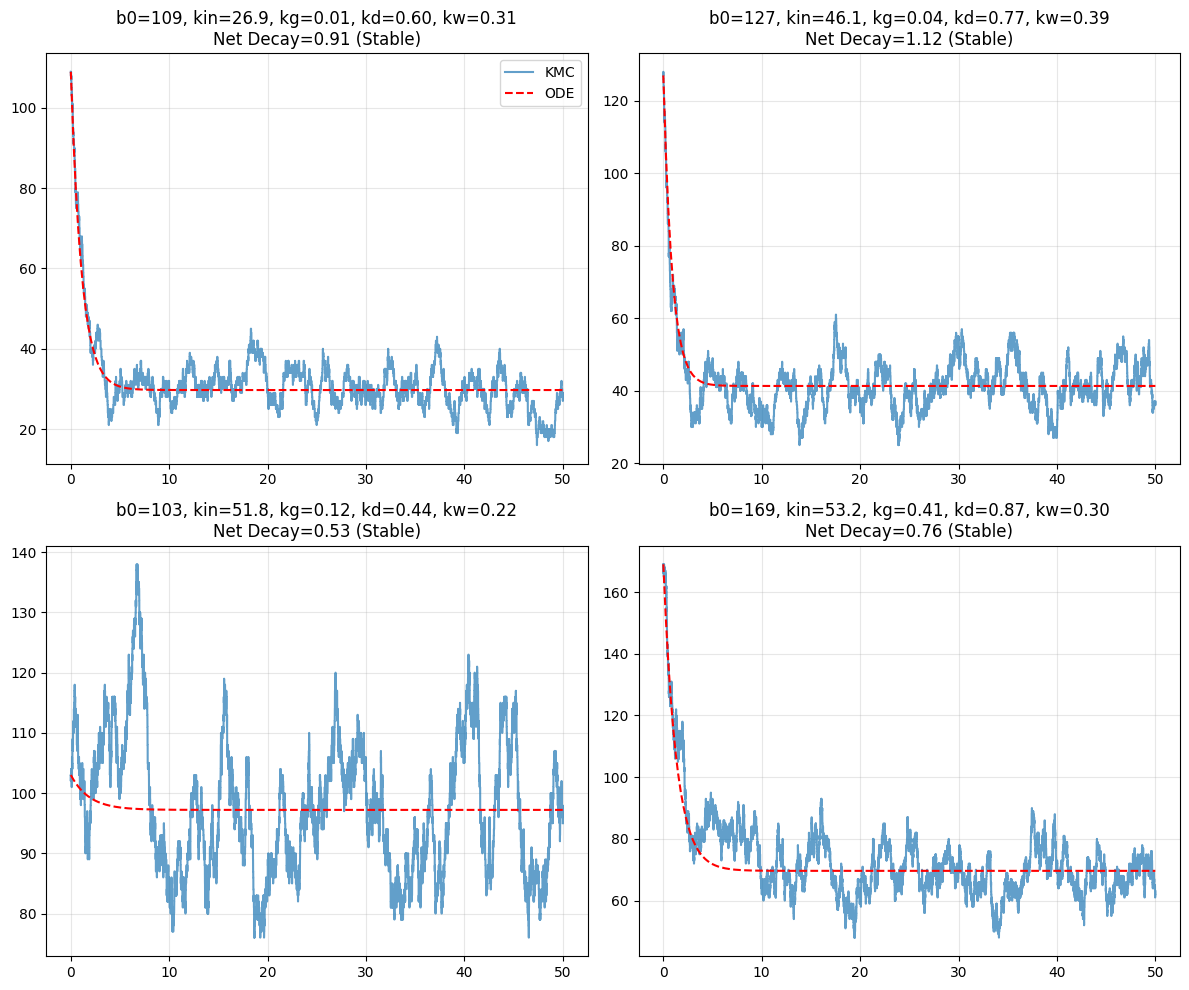

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    
    b0 = np.random.randint(50, 250)
    kg = np.random.uniform(0.0, 0.5)
    kin = np.random.uniform(10, 60)
    kd = np.random.uniform(0.3, 0.9)
    kw = np.random.uniform(0.1, 0.4)
    
    tk, nk = kmc_simulation(b0, end_time, kin, kg, kd, kw)
    
    to = np.linspace(0, end_time, 200)
    no = ode(to, b0, kin, kg, kd, kw)
    
    net = (kd + kw) - kg
    status = "Stable" if net > 0 else "Unstable"
    
    ax.step(tk, nk, where='post', alpha=0.7, label='KMC')
    ax.plot(to, no, 'r--', label='ODE')
    ax.set_title(f"b0={b0}, kin={kin:.1f}, kg={kg:.2f}, kd={kd:.2f}, kw={kw:.2f}\nNet Decay={net:.2f} ({status})")
    ax.grid(True, alpha=0.3)
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

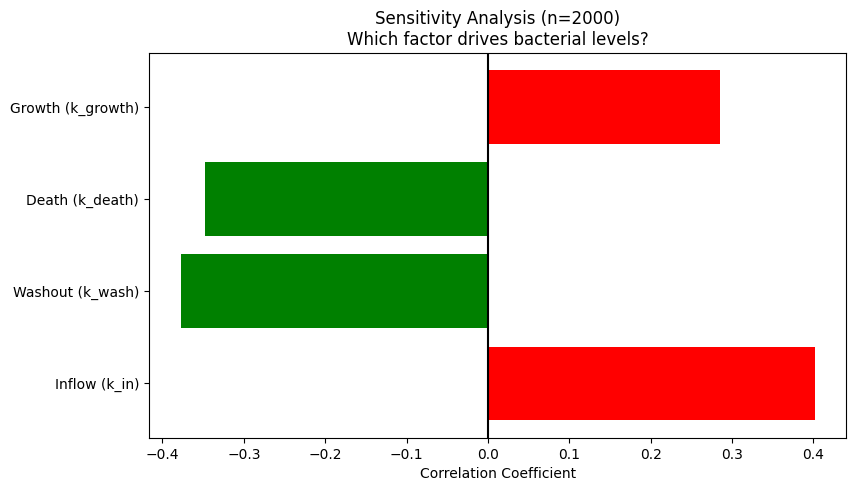

In [79]:
# --- SENSITIVITY ANALYSIS ---
n_sims = 2000
np.random.seed(42) # Seed for consistent analysis results

# Generate arrays of random parameters
kin_s = np.random.uniform(10, 80, n_sims)
kw_s  = np.random.uniform(0.1, 0.8, n_sims)
kd_s  = np.random.uniform(0.1, 0.8, n_sims)
kg_s  = np.random.uniform(0.0, 0.5, n_sims)

final_vals = []

for i in range(n_sims):
    net = (kd_s[i] + kw_s[i]) - kg_s[i]
    
    if net <= 0:
        val = 1000 # Cap failure at 1000 for plotting
    else:
        # Steady state calculation
        val = kin_s[i] / net
    final_vals.append(val)

final_vals = np.array(final_vals)

# Correlation Analysis
inputs = np.column_stack((kin_s, kw_s, kd_s, kg_s))
names = ['Inflow (k_in)', 'Washout (k_wash)', 'Death (k_death)', 'Growth (k_growth)']
corrs = []

# Only analyze stable cases (value < 999) to avoid skewing data
valid = final_vals < 999
for i in range(4):
    c = np.corrcoef(inputs[valid, i], final_vals[valid])[0,1]
    corrs.append(c)

# Plot
plt.figure(figsize=(9, 5))
colors = ['red' if c > 0 else 'green' for c in corrs]
plt.barh(names, corrs, color=colors)
plt.axvline(0, color='black')
plt.title(f"Sensitivity Analysis (n={n_sims})\nWhich factor drives bacterial levels?")
plt.xlabel("Correlation Coefficient")
plt.show()